Check Python version

In [812]:
!python --version

Python 3.11.6


Import libraries

In [813]:
import json
import yaml
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### **Extract Data**

In [814]:
# Through online GitHub
file_name = 'https://github.com/ourownstory/neuralprophet-data/raw/main/datasets/air_passengers.csv'

In [815]:
train_df = pd.read_csv(file_name)

In [816]:
train_df.shape

(144, 2)

In [817]:
train_df.columns

Index(['ds', 'y'], dtype='object')

In [818]:
train_df.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [819]:
train_df.tail()

,ds,y
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390
143,1960-12-01,432


Define the required time and target columns

In [820]:
time_col = train_df.columns[0]
target_col = train_df.columns[-1]
train_df[time_col] = train_df[time_col].astype(str)

Change target column to float

In [821]:
train_df[target_col] = train_df[target_col].astype(float)

In [822]:
train_df.head()

,ds,y
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Plot graph

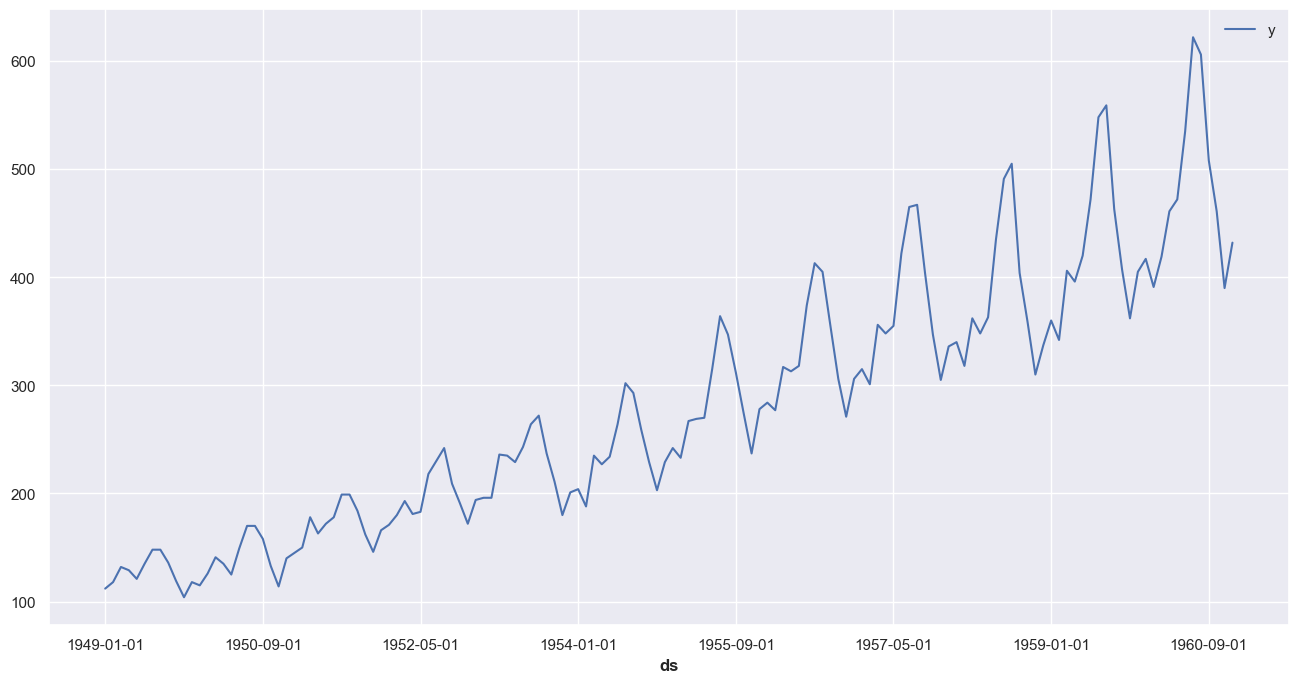

In [823]:
figsize = (16, 8)
train_df.set_index(time_col).plot(figsize=figsize);

### **Train API**

Train data: convert df to list-of-list

In [824]:
train_data = []

In [825]:
for value in train_df.values:
    train_data.append(list(value))

In [826]:
train_data[:10]

[['1949-01-01', 112.0],
 ['1949-02-01', 118.0],
 ['1949-03-01', 132.0],
 ['1949-04-01', 129.0],
 ['1949-05-01', 121.0],
 ['1949-06-01', 135.0],
 ['1949-07-01', 148.0],
 ['1949-08-01', 148.0],
 ['1949-09-01', 136.0],
 ['1949-10-01', 119.0]]

Define Model Request (optional)

In [836]:
# Default model request
np_model_request = {
    "params": {
      "changepoints_range": 0.2,
      "epochs": 2,
      "growth": "off"
    },
    "metrics": [],
    "type": "neuralprophet",
}

model_request = {
    'type': 'meta_wa',  # 'meta_wa'
    'scorers': ['smape', 'mape'],
    'params': {
        'preprocessors': [
            {'type': 'simpleimputer', 'params': {'strategy': 'mean'}},
            {'type': 'minmaxscaler'},
        ],
        'base_models': [
            {'type': 'darts_autoets'},
            #{'type': 'darts_autoarima'},
            #{'type': 'darts_autotheta'},
            #{'type': 'stats_autotheta'},
            {'type': 'neuralprophet', 'external_params':np_model_request }#neuralprophet
        ],
    },
}

# Customized model request
# model_request = {
#     'type': 'meta_wa',
#     'scorers': ['smape', 'mape'],
#     'param': {
#         'base_models': [
#             {'type': 'darts_autoarima'},
#             {'type': 'darts_autotheta'},
#             {'type': 'darts_autoets'},
#             {'type': 'stats_autotheta'},
#         ],
#     },
# }

Train API JSON Payload

In [837]:
api_json = {
    'data': train_data,
    'model': model_request  # (optional) can be commented out
}

Build URL

In [838]:
with open('url.yaml', 'r') as file:
    url_dict = yaml.safe_load(file)

In [839]:
# URL to our SYBIL AWS service
protocol = url_dict['protocol']
host = url_dict['host']
port = url_dict['port']
endpoint = 'train'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

In [840]:
# protocol, host, port

Call endpoint, receive response JSON, write to output file

In [845]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [500]>

CPU times: user 4.99 ms, sys: 2.72 ms, total: 7.71 ms
Wall time: 1min 4s


In [776]:
train_json_out = response.json()  # dict output
train_json_out

{'model': 'AgEBCMD4AQDA+AEArykBABQAAAAXIgAAP4AAZWxzTZOMbyh0cpRzjG1vbnQUcnQpdF+MdGVlk4xkH22UeWGUcoFffWFyYmRilGSUlHlujElBkyiUc25hlERJH2h0eARwbGFwY3JlYXJzbXRyXIyMk4iM//9uAYxjdIxzH5RyAJSFlEv//24BiRanS9wer/GCE1XmKLlK7n/BUpQlH7b4ictc7ZEiZPU3yFmbLG7/kIMUVucpukuNHmDxgia3H/mKzF3uMMEDlCXJWpwtbwCR02SmN8hs/T/QEqM0dgdJH9prXu8xwgSVJmj5O8xdAZLUZac4yQuc3m8ApDV3CErbH2yuP4ESo0fYGqvtfg9R4iS1RjnKDJ3fcAFD1BaUZl+UH5SMGF9DYQluYm6BaCkuc25hZZRulEtSlIkDSv9dlJQCFVJOdGmUb2l9YXJlZJSUeCi4lACUaADghgAflF9zdGYKZ4mUlJSUcpRtlH1OlIWDbWiUbWFoYYFobSgHlEuHlEv//4DghrYfAGh0dpRhaIZtlHNtlF9yFHZvGF9vc2FycmZvX054c2kMFWFyjHRfdHV1coxkdIAKH3RyjGENcAtpcmMobk5ulAhzc28uc3J1bpQJdIw0Bk5fH2UTY25lX2xrX3RhdXKMYXKMdXaUdHJwcGg1lEuJTl9lAZR0wAofYXJ0bpRkYWFsb4EMWm1hAWUGR61AjIyUOoZjQGXH24wfIe2UaXRzB5RLUpQCrIQxLEBEYW25+7STJJQlaIcPQtofCOaTfykcndOCUbBnGvxV9Ib59Bpi4R9Db1R7r1OQ1o8f3NXAdqVJ9Tv7rchqOme315BQWwPkDrrE0mN76NfLtWMf3z19kvDXrxrY7Eolo989QckjxlyIB7/Dn9jcrH/aAVYf3zAeZE7jFlcmzCxckOCZWWWphSOUgkMpV/fd71iH1jAfHAdkJM1qLvibSd4FqIHafwajd7svUHnfgLwbt8cAI

### **Forecast API**

Forecast Dates: predict the next 2 years of air passenger data (1961-1962)

In [777]:
dates = [
    '1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01', '1961-05-01', '1961-06-01',
    '1961-07-01', '1961-08-01', '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01',
    '1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01', '1962-05-01', '1962-06-01',
    '1962-07-01', '1962-08-01', '1962-09-01', '1962-10-01', '1962-11-01', '1962-12-01',
]

Model from Train API

In [778]:
model = train_json_out['model']

Forecast API JSON Payload

In [779]:
api_json = {
    'model': model,
    'data': dates
}

Build URL (same as train except for the endpoint)

In [780]:
endpoint = 'forecast'

url = '%s://%s:%s/%s' % (protocol, host, str(port), endpoint)

Call endpoint, receive response JSON, write to output file

In [781]:
%%time
response = requests.post(url, json=api_json)
print(response)
print()

<Response [200]>

CPU times: user 4 ms, sys: 2.32 ms, total: 6.32 ms
Wall time: 145 ms


In [782]:
forecast_json_out = response.json()  # dict output
forecast_json_out

{'data': [['1960-12-31T00:00:00', 410.0689018335762],
  ['1961-01-30T00:00:00', 318.17103705160935],
  ['1961-03-01T00:00:00', 29.966533687747685],
  ['1961-03-31T00:00:00', -368.6884168817672],
  ['1961-04-30T00:00:00', -503.3708110862486],
  ['1961-05-30T00:00:00', 11.635895455355502],
  ['1961-06-29T00:00:00', -31.33629401022094],
  ['1961-07-29T00:00:00', -2.875804648246998],
  ['1961-08-28T00:00:00', -73.8386498241747],
  ['1961-09-27T00:00:00', 40.861794824713584],
  ['1961-10-27T00:00:00', -182.7206424936656],
  ['1961-11-26T00:00:00', -131.85438195846146],
  ['1961-12-26T00:00:00', 406.346727086611],
  ['1962-01-25T00:00:00', 322.1298944413404],
  ['1962-02-24T00:00:00', 31.151180785523913],
  ['1962-03-26T00:00:00', -363.57587103046757],
  ['1962-04-25T00:00:00', -507.5625588426597],
  ['1962-05-25T00:00:00', 10.66501700862824],
  ['1962-06-24T00:00:00', -31.62771369678383],
  ['1962-07-24T00:00:00', -1.8536886477871448],
  ['1962-08-23T00:00:00', -75.03104180932465],
  ['1962

Combine forecast dates and output

In [783]:
forecast_df = pd.DataFrame(
    data=forecast_json_out['data'],
    columns=[time_col, target_col],
)

In [784]:
forecast_df.shape

(24, 2)

In [785]:
forecast_df.columns

Index(['ds', 'y'], dtype='object')

In [786]:
forecast_df.head()

,ds,y
0,1960-12-31T00:00:00,410.068902
1,1961-01-30T00:00:00,318.171037
2,1961-03-01T00:00:00,29.966534
3,1961-03-31T00:00:00,-368.688417
4,1961-04-30T00:00:00,-503.370811


In [787]:
forecast_df.tail()

,ds,y
19,1962-07-24T00:00:00,-1.853689
20,1962-08-23T00:00:00,-75.031042
21,1962-09-22T00:00:00,41.530225
22,1962-10-22T00:00:00,-181.258915
23,1962-11-21T00:00:00,-134.528968


Plot train and forecast side-by-side

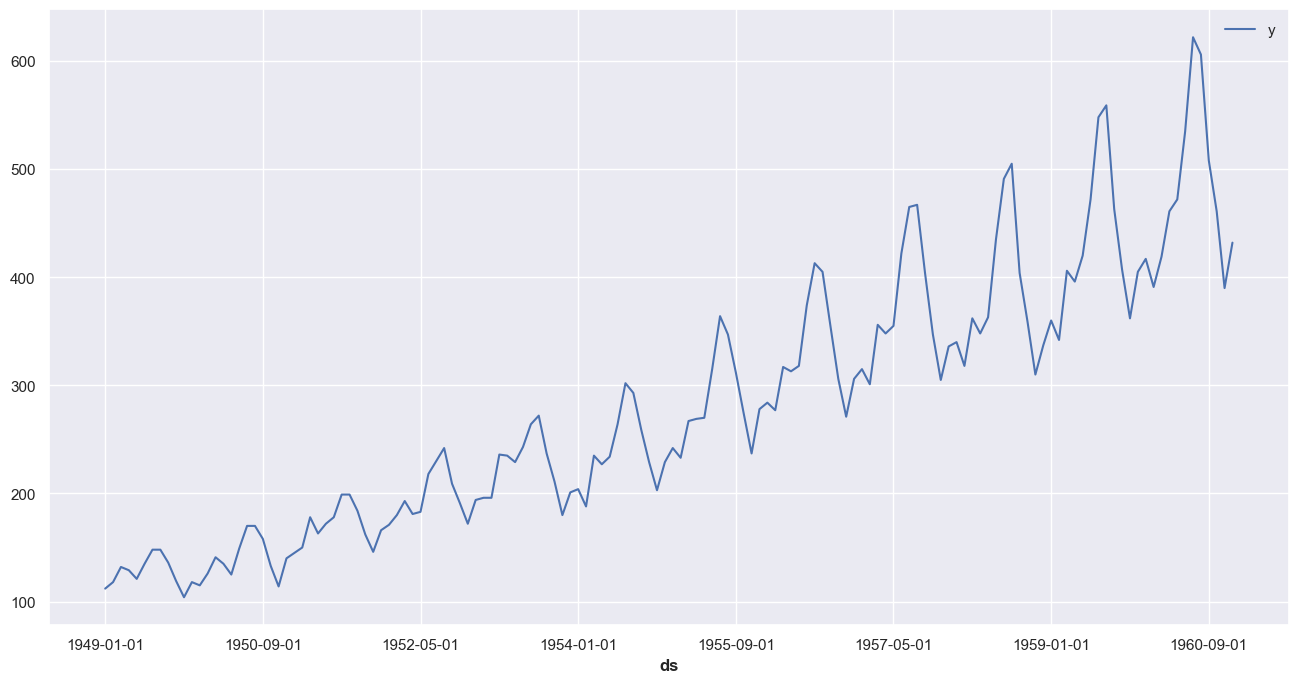

In [788]:
train_df['color'] = 'b'
train_df.set_index(time_col).plot(figsize=figsize, color=train_df['color']);

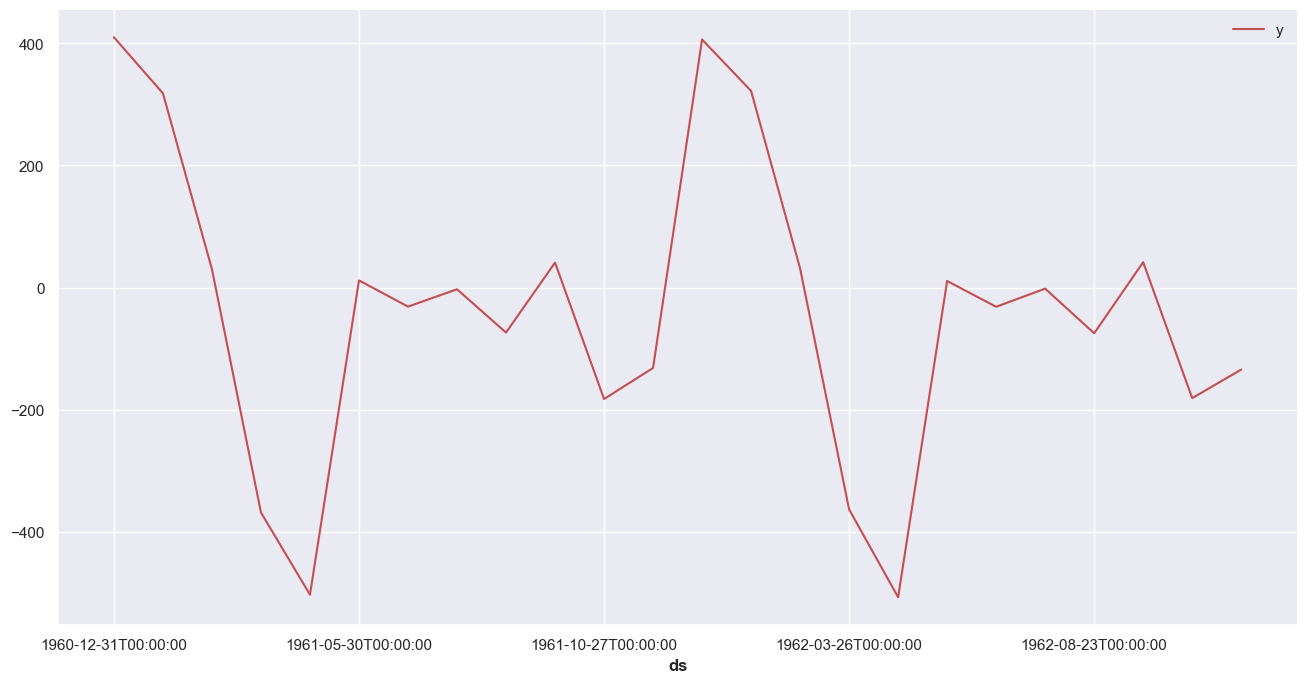

In [789]:
forecast_df['color'] = 'r'
forecast_df.set_index(time_col).plot(figsize=figsize, color=forecast_df['color']);

Combine train and test sets

In [749]:
df = pd.concat([train_df, forecast_df]).reset_index(drop=True)

In [37]:
df.shape

(168, 3)

In [38]:
df.head()

,ds,y,color
0,1949-01-01,112.0,b
1,1949-02-01,118.0,b
2,1949-03-01,132.0,b
3,1949-04-01,129.0,b
4,1949-05-01,121.0,b


In [39]:
df.tail()

,ds,y,color
163,1962-07-24T00:00:00,711.691483,r
164,1962-08-23T00:00:00,603.724986,r
165,1962-09-22T00:00:00,533.255271,r
166,1962-10-22T00:00:00,450.844267,r
167,1962-11-21T00:00:00,512.190425,r


Plot combined train and test sets with the vertical black line as the cut-off

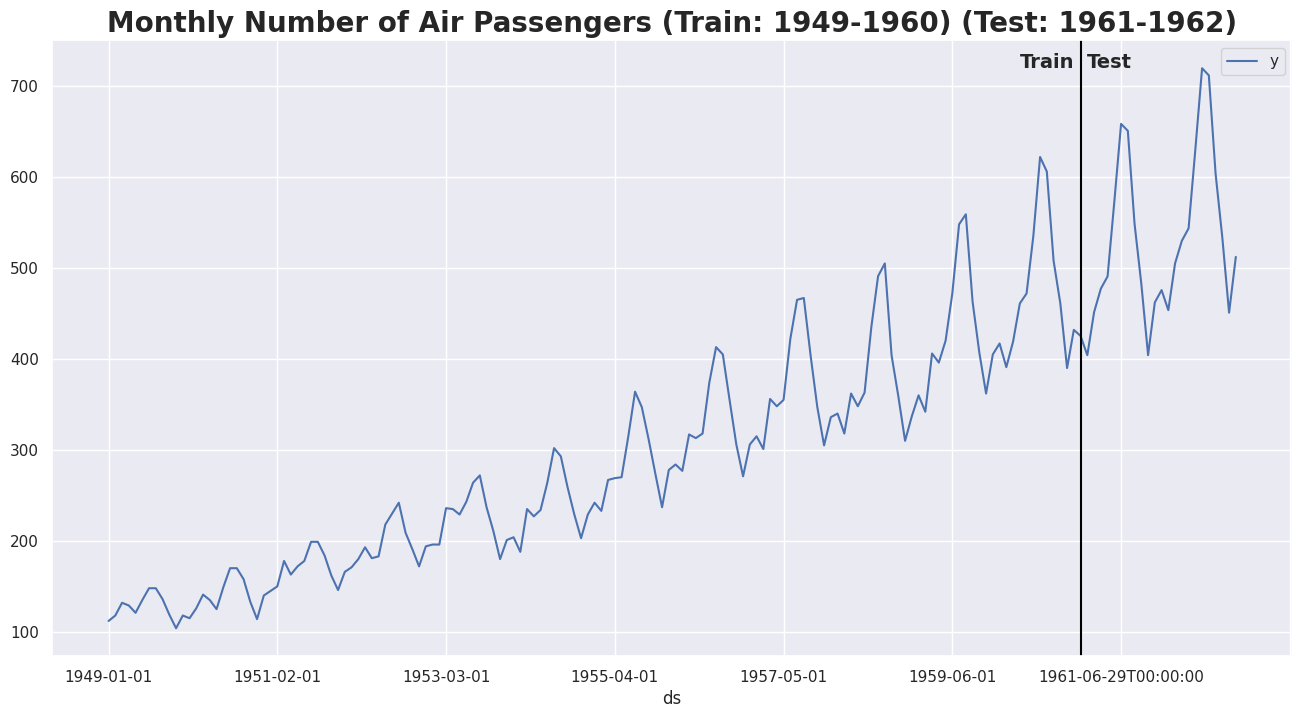

In [40]:
df.set_index(time_col).plot(figsize=figsize, color=df['color'])
plt.axvline(x=len(train_df), color='black', label='Train/Test set cut-off')
plt.text(x=len(train_df)-9, y=forecast_df[target_col].max(), s='Train', fontweight='bold', fontsize=14)
plt.text(x=len(train_df)+1, y=forecast_df[target_col].max(), s='Test', fontweight='bold', fontsize=14)
plt.title(label='Monthly Number of Air Passengers (Train: 1949-1960) (Test: 1961-1962)', fontweight='bold', fontsize=20)
plt.show();